# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# !pip install -U torch torchvision

In [1]:
from collections import Counter
import torch
import numpy as np
import PIL
import torchvision

!nvidia-smi
torch.cuda.is_available()

train_on_gpu = torch.cuda.is_available()


if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

Wed Apr 19 08:28:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   40C    P8    11W / 151W |   1519MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
torch.cuda.is_available()

train_on_gpu = torch.cuda.is_available()


if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


In [5]:
import torch
torch.zeros(1).cuda()
# torch.cuda.is_available()

tensor([0.], device='cuda:0')

In [6]:
# установка подходящей версии torch

from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [7]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
import PIL
# print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [9]:
import torchvision

In [10]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [11]:
# !unzip -q /content/gdrive/My\ Drive/DLS/simpsons/journey-springfield.zip -d train

In [12]:
# !unzip -q /content/gdrive/My\ Drive/DLS/simpsons/data/dataset.zip -d train
# !unzip -q /content/gdrive/My\ Drive/DLS/simpsons/data/testset.zip -d test

In [13]:
# !ls "gdrive/MyDrive/simpsons/simpsons_dataset"
# !ls gdrive/MyDrive/DLS/simpsons/simpsons_dataset
# !pwd

In [14]:
# |!pwd
# %cd gdrive

In [15]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Apr 19 08:32:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   40C    P8    11W / 151W |   1883MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [16]:
# !pip install torchvision

In [17]:
# !pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

In [18]:
# !pip install -q torch==1.0.0 torchvision

In [19]:
# !pip install -U scikit-image

In [20]:
import torchvision

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [21]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [22]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
DEVICE = torch.device("cpu")
DEVICE

device(type='cpu')

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [33]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#             transforms.functional.adjust_gamma(gamma = uniform(0.5, 5.0)),
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [25]:
# train_dataset.targets

In [26]:
def visualize(image):
    """ Метод визуализации изображения"""
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow метод визуализации для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


In [27]:
# PATH = "gdrive/MyDrive/DLS/simpsons/"
PATH = "simpsons_datasets/"

# TRAIN_DIR = Path('train/dataset')
# TEST_DIR = Path('test/testset')
TRAIN_DIR = Path(PATH+'train_dataset')
TEST_DIR = Path(PATH+'test_dataset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [28]:
train_val_files

[WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0004.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0005.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0006.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0007.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0008.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0009.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simpson/pic_0010.jpg'),
 WindowsPath('simpsons_datasets/train_dataset/abraham_grampa_simp

In [29]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [34]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [35]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

ValueError: operands could not be broadcast together with shapes (3,) (224,3,224) 

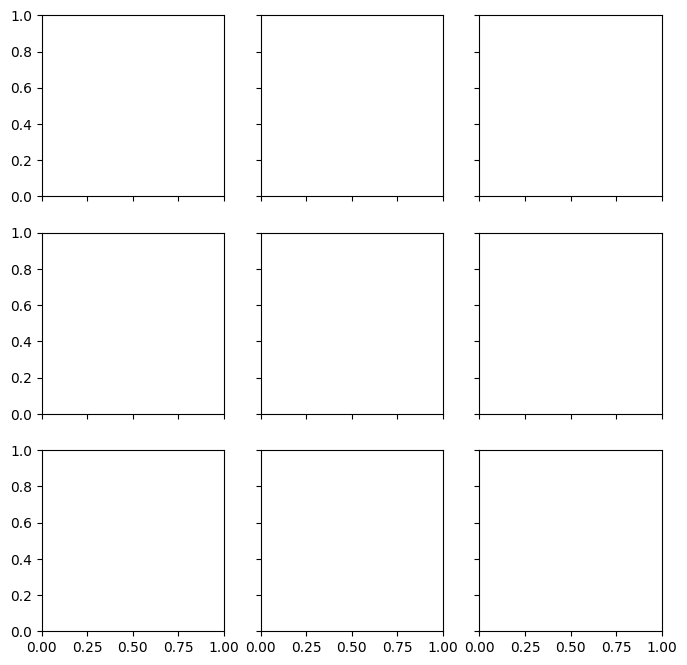

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [47]:
DEVICE

device(type='cpu')

In [536]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [537]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader, position = 0, leave=True):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [538]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [83]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [84]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [85]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [86]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [117]:
type(train_dataset)

__main__.SimpsonsDataset

In [89]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

100%|██████████| 246/246 [05:03<00:00,  1.23s/it]


loss 2.416715412453046


epoch:  50%|█████     | 1/2 [06:13<06:13, 373.63s/it]


Epoch 001 train_loss: 2.4167     val_loss 1.7076 train_acc 0.3294 val_acc 0.5369


100%|██████████| 246/246 [04:01<00:00,  1.02it/s]


loss 1.3729725811570928


epoch: 100%|██████████| 2/2 [11:04<00:00, 332.09s/it]


Epoch 002 train_loss: 1.3730     val_loss 1.2156 train_acc 0.6257 val_acc 0.6683


Построим кривые обучения

In [91]:
loss, acc, val_loss, val_acc = zip(*history)

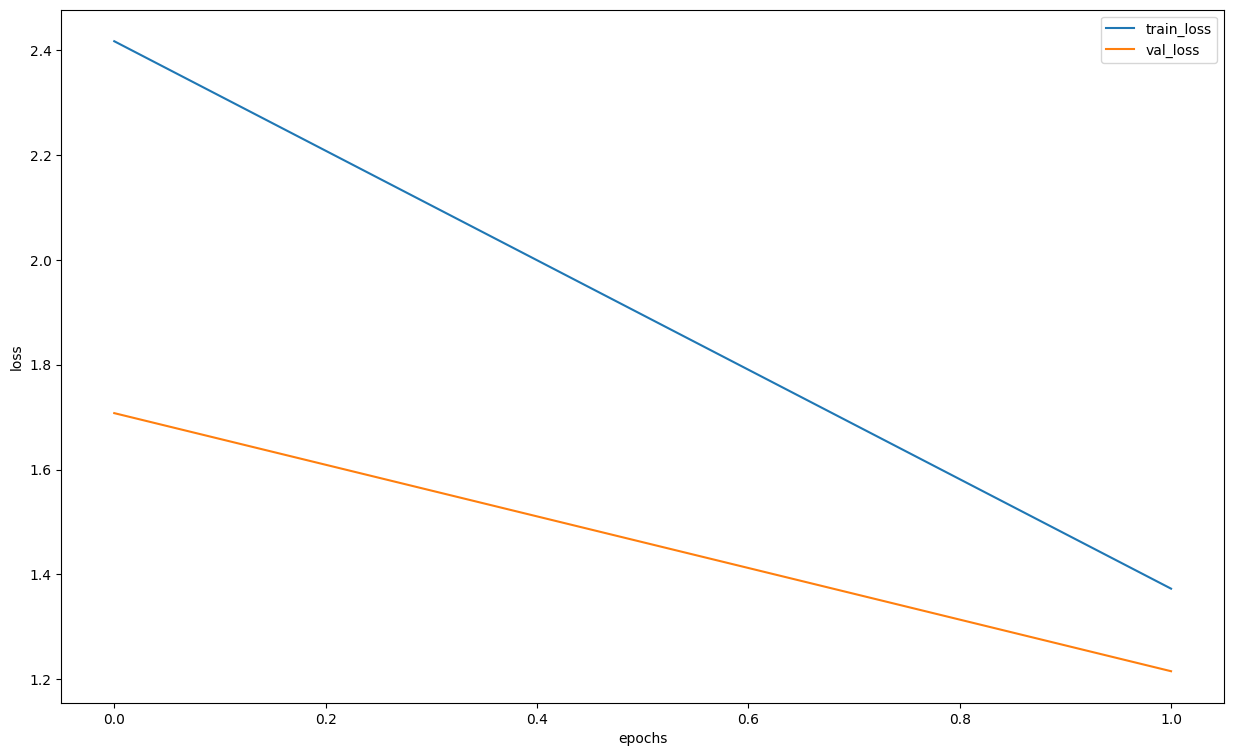

In [92]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [528]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [529]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [530]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [531]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [532]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [533]:
len(y_pred)

20

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [534]:
from sklearn.metrics import f1_score

# f1_score(actual_labels, preds_class)
f1_score(actual_labels, list(y_pred), average='micro')



0.7

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

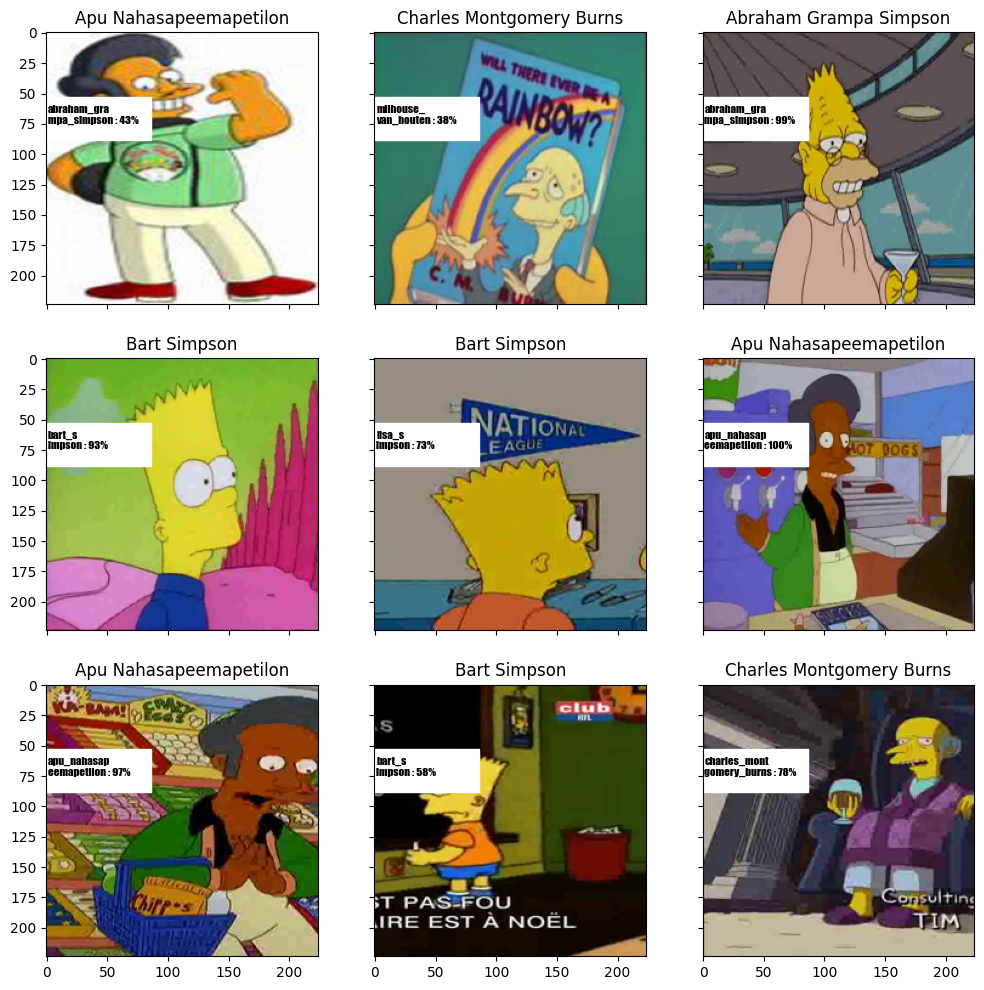

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [535]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [113]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [114]:
! ls 

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [ ]:
import pandas as pd
my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


### /Первичный анализ
При анализе данных, первое что бросается в глаза это дисбаланс классов.
Первое желание было сгенерировать с помощью аугментации доподнительные данные испоьлзуя популярные библиотеки (например albumentations).
Идея была в увеличении самого датасета за счет генерации аугментированных изображений таким образом, чтобы в тренировочном датасете для каждого класса было не менее 1000 примеров.
При изучении вопроса вяснилось, что подход в корне другой 



Импортируем необходимые библиотеки

In [696]:
from multiprocessing.pool import ThreadPool
from pathlib import Path

import numpy as np
import pandas as pd
from collections import Counter

import PIL
from PIL import Image
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import io

from tqdm import tqdm, tqdm_notebook

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


Определяем наличие поддержки GPU

In [697]:
# !nvidia-smi
torch.cuda.is_available()
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    # работаем на процессоре
    print('CUDA не доступна.  Работаем на CPU ...')
    DEVICE = torch.device("cpu")    
else:
    # работаем на видеокарте
    print('CUDA доступна! Работаем на GPU ...')
    DEVICE = torch.device("cuda")

CUDA не доступна.  Работаем на CPU ...


Объявляем константы

In [698]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
PATH = "simpsons_datasets/"
TRAIN_DIR = Path(PATH+'train_dataset')
TEST_DIR = Path(PATH+'test_dataset')
# загрузка данных
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [699]:
# augmenters = {
#     'Crop': transforms.Compose([
#                                 transforms.Resize(size=300, max_size=400),
#                                 transforms.CenterCrop(size=300),
#                                 transforms.RandomCrop(250)
#                                 ]),
#     'Rotate': transforms.RandomRotation(degrees=(-35, 35)),
#     'HFlip': transforms.RandomHorizontalFlip(p=0.7),
#     'test':     transforms.Compose([
#                         transforms.Resize(size=300, max_size=301),
#                         transforms.CenterCrop(size=300),
#                         transforms.RandomCrop(250),
#                         transforms.RandomRotation(degrees=(-30, 30)),
#                         transforms.RandomHorizontalFlip(p=0.5)
#                         ]),
#     'test2':     transforms.Compose([
#                         transforms.Compose([
#                             transforms.Resize(size=300, max_size=401),
#                             transforms.CenterCrop(size=300),
#                             transforms.RandomCrop(250),
#                         ]),
#                         transforms.RandomRotation(degrees=(-30, 30)),
#                         transforms.RandomHorizontalFlip(p=0.5)
#                         ]),
# }


In [700]:
# def load_image(file):
#     image = Image.open(file)
#     image.load()
#     return image
# n_examples = 3

# fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

# for i in range(n_examples):
#     random_character = int(np.random.uniform(0, len(train_val_files)))
#     img_orig = load_image(train_val_files[random_character])
#     img_label = train_val_files[random_character].parent.name

#     img_label = " ".join(map(lambda x: x.capitalize(),\
#                 img_label.split('_')))
#     ax[i][0].imshow(img_orig)
#     ax[i][0].set_title(img_label)
#     ax[i][0].axis('off')
        
#     for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
#         img_aug = augmenter(img_orig)
#         ax[i][j + 1].imshow(img_aug)
#         ax[i][j + 1].set_title(augmenter_name)
#         ax[i][j + 1].axis('off')

In [701]:
#         if self.mode == "train": 
#             transforms.Compose([
#                                     transforms.Compose([
#                                         transforms.Resize(size=300, max_size=401),
#                                         transforms.CenterCrop(size=300),
#                                         transforms.RandomCrop(250),
#                                     ]),
#                                     transforms.RandomRotation(degrees=(-30, 30)),
#                                     transforms.RandomHorizontalFlip(p=0.5)
#                                     ])
#         else:
            

In [702]:
# augmenters = {
#     transforms.Compose([
#                         transforms.Resize(size=300, max_size=301),
#                         transforms.CenterCrop(size=300),
#                         transforms.RandomCrop(250)
#                         ]),
#     transforms.RandomRotation(degrees=(-30, 30)),
#     transforms.RandomHorizontalFlip(p=1)
# }

In [703]:
#         if self.mode == "train": 
#             augmentations = transforms.RandomChoice([
#                                    transforms.Compose([
#                                        transforms.Resize(size=313, max_size=333),
#                                        transforms.CenterCrop(size=300),
#                                        transforms.RandomCrop(250)
#                                        ]),
#                                    transforms.RandomRotation(degrees=(-33, 33)),
#                                    transforms.RandomHorizontalFlip(p=1),
#                                    ])
#             transform = transforms.Compose([
#                                     augmentations,
#                                     transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
#                                     transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                     ]) 
                
#         else:
#             transform = transforms.Compose([
#                         transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
#                         transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
#                         transforms.ToTensor(),
#                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
#                     ])
            
        

In [704]:

#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#         ])
        

In [705]:
# BATCH_SIZE = 256
# RESCALE_SIZE = 224
# augmentations = transforms.RandomChoice([
#     transforms.Compose([
#         transforms.Resize(size=300, max_size=301),
#         transforms.CenterCrop(size=300),
#         transforms.RandomCrop(250)
#     ]),
#     transforms.RandomRotation(degrees=(-25, 25)),
#     transforms.RandomHorizontalFlip(p=1),
# ])
# train_transforms = transforms.Compose([
#     augmentations,
#     transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
#     transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
# ])
# train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

Определяем класс SimpsonsDataset (наследуем от Dataset).
В классе SimpsonsDataset определяем необходмые процедуры по загрузке и предобработке данных 

In [724]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == "train": 
#             random_augmentations = transforms.RandomChoice([
#                 transforms.Compose([
#                     transforms.Resize(size=300, max_size=401),
#                     transforms.CenterCrop(size=300),
#                     transforms.RandomCrop(244),
#                 ]),
#                 transforms.RandomRotation(degrees=(-30, 30)),
#                 transforms.RandomHorizontalFlip(p=1),
#             ])
#             transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                 random_augmentations,
#             ])
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                 transforms.RandomChoice([
                transforms.Compose([
                    transforms.Resize(size=300, max_size=401),
                    transforms.CenterCrop(size=300),
                    transforms.RandomCrop(250),
                ]),
                transforms.RandomRotation(degrees=(-30, 30)),
                transforms.RandomHorizontalFlip(p=0.5),
#                 ]),
            ])
        else:        
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
        

        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Определяем методы по визуализации данных. 
Обычный метод визуализации загруженных изображений и визуализации изображений в виде тензоров

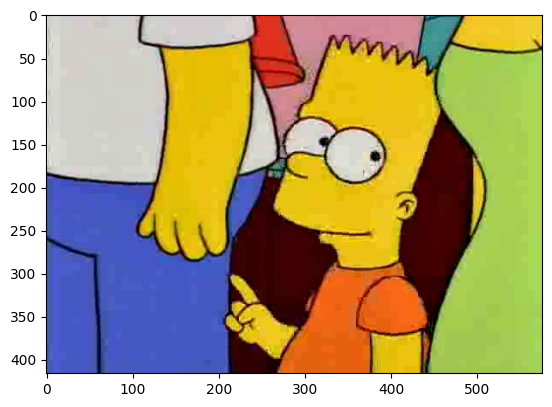

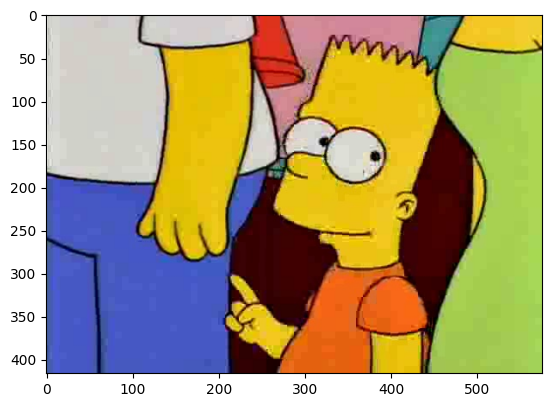

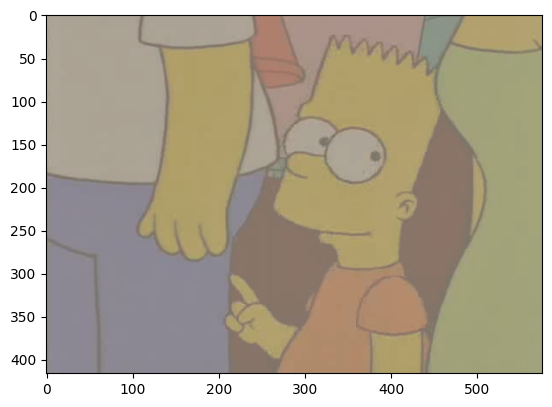

In [707]:
def visualize(image):
    """ Метод визуализации изображения"""
    plt.figure()
    plt.imshow(image)
    return plt

def visualize_tensor(inp):
    """
    Метод визуализации для тензоров
    При переводе в тензор каналы цветов перемещены на первую позицию, 
    а при обычной загрузке каналы цветов расположены в конце.
    Поэтому перед визуализацией делается доп. преобразование
    """
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure()
    plt.imshow(inp)

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow метод визуализации для тензоров с нормализацией. Метод взят из бейзлайна"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure()
    plt_ax.imshow(inp)
    plt.rc('font', size=10) 
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

    
image = Image.open(train_val_files[2000])
image.load()

visualize(image)
visualize_tensor(transforms.ToTensor()(image))
imshow(transforms.ToTensor()(image))

# np.array(image).shape
# np.array(image).shape, transforms.ToTensor()(image).shape, transforms.ToTensor()(image).numpy().shape, np.array(transforms.ToPILImage()(transforms.ToTensor()(image))).shape
# np.array(transforms.ToPILImage()(transforms.ToTensor()(image))) == np.array(image)    


### Подготовливаем данные

In [708]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [709]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Проверка загруженных данных

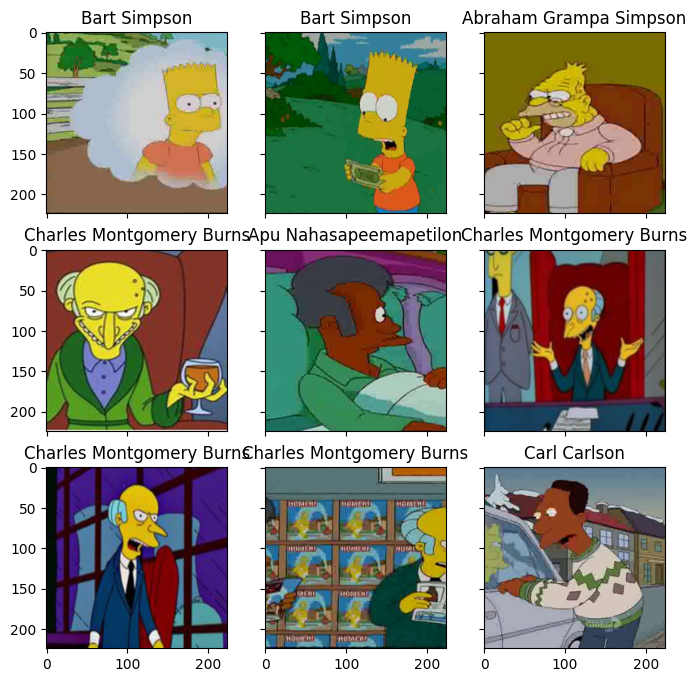

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [710]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

In [711]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [712]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader, position = 0, leave=True):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [713]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [714]:
# Формируем распределение данных для выгрузки из DataLoader сбалансированных данных
def create_sampler(ds):
    print(len(ds))
    class_count = Counter(ds.labels)
    class_weights = {name: 1/cnt for name, cnt in class_count.items()}

    sample_weights = [0] * len(ds)
    for i, label in enumerate(ds.labels):
        class_weight = class_weights[label]
        sample_weights[i] = class_weight
    # Максимальное кол-во объкетов = максимальное кол-во записей среди всех классов в трейне * на кол-во классов  
    N_count = max(class_count.values()) * len(class_count)

    sampler = WeightedRandomSampler(sample_weights, num_samples=N_count, replacement=True)
    return sampler

In [715]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=create_sampler(train_dataset))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=create_sampler(val_dataset))
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [716]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [717]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNor

In [718]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [725]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=64)

15699
5234


epoch:   0%|          | 0/4 [00:01<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [3, 250, 250] at entry 0 and [3, 224, 224] at entry 1

In [691]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=3, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [40:12<00:00,  2.18s/it] 


loss 1.237701373515039


epoch:  33%|███▎      | 1/3 [45:41<1:31:23, 2741.86s/it]


Epoch 001 train_loss: 1.2377     val_loss 1.6255 train_acc 0.6735 val_acc 0.6407


100%|██████████| 1106/1106 [40:03<00:00,  2.17s/it]


loss 0.6232271854113756


epoch:  67%|██████▋   | 2/3 [1:30:46<45:19, 2719.98s/it]


Epoch 002 train_loss: 0.6232     val_loss 1.4480 train_acc 0.8327 val_acc 0.6826


100%|██████████| 1106/1106 [33:41<00:00,  1.83s/it]


loss 0.42601087298962664


epoch: 100%|██████████| 3/3 [2:09:12<00:00, 2584.25s/it]



Epoch 003 train_loss: 0.4260     val_loss 1.2764 train_acc 0.8834 val_acc 0.7310


In [693]:
loss, acc, val_loss, val_acc = zip(*history)

ValueError: not enough values to unpack (expected 4, got 0)

In [726]:
model=simple_cnn
batch_size=64
epochs = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=create_sampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=create_sampler(val_dataset))

history = []
log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


15699
5234


In [581]:
 
with tqdm(desc="epoch", total=epochs) as pbar_outer:

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        print("loss", train_loss)

        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))

        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

100%|██████████| 1106/1106 [21:04<00:00,  1.14s/it]


loss 0.6990244960558386


epoch: 100%|██████████| 1/1 [25:19<00:00, 1519.89s/it]


Epoch 001 train_loss: 0.6990 val_loss 2.1013 train_acc 0.8206 val_acc 0.5907


In [582]:
 
with tqdm(desc="epoch", total=epochs) as pbar_outer:

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        print("loss", train_loss)

        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))

        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

100%|██████████| 1106/1106 [20:12<00:00,  1.10s/it]


loss 0.21290315487033867


epoch: 100%|██████████| 1/1 [24:26<00:00, 1466.08s/it]


Epoch 001 train_loss: 0.2129 val_loss 2.6080 train_acc 0.9416 val_acc 0.6300


In [583]:
 
with tqdm(desc="epoch", total=epochs) as pbar_outer:

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        print("loss", train_loss)

        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))

        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

100%|██████████| 1106/1106 [20:16<00:00,  1.10s/it]


loss 0.1042162594489338


epoch: 100%|██████████| 1/1 [24:29<00:00, 1469.48s/it]


Epoch 001 train_loss: 0.1042 val_loss 2.7754 train_acc 0.9708 val_acc 0.6521


In [584]:
 
with tqdm(desc="epoch", total=epochs) as pbar_outer:

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        print("loss", train_loss)

        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))

        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

100%|██████████| 1106/1106 [20:06<00:00,  1.09s/it]


loss 0.07202112532161316


epoch: 100%|██████████| 1/1 [24:17<00:00, 1457.26s/it]


Epoch 001 train_loss: 0.0720 val_loss 2.9029 train_acc 0.9792 val_acc 0.6740


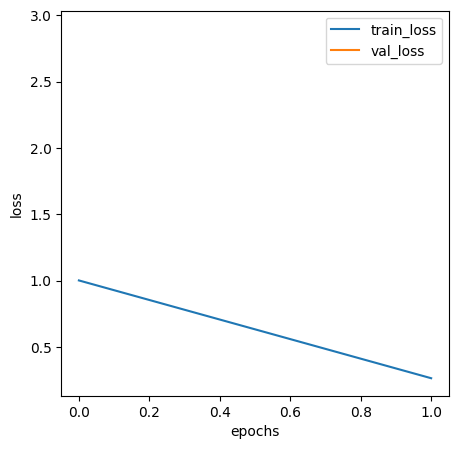

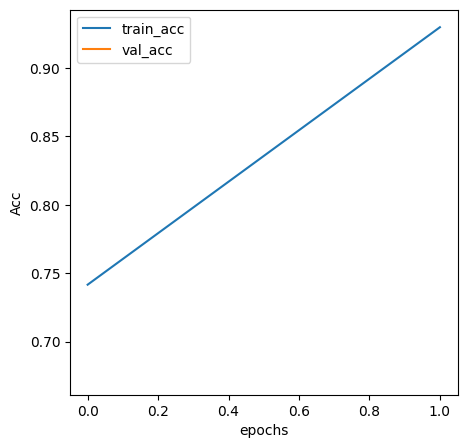

In [587]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

In [588]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [589]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [590]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [591]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [592]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [1]:
len(y_pred)

NameError: name 'y_pred' is not defined

In [594]:
from sklearn.metrics import f1_score

# f1_score(actual_labels, preds_class)
f1_score(actual_labels, list(y_pred), average='micro')



0.8000000000000002

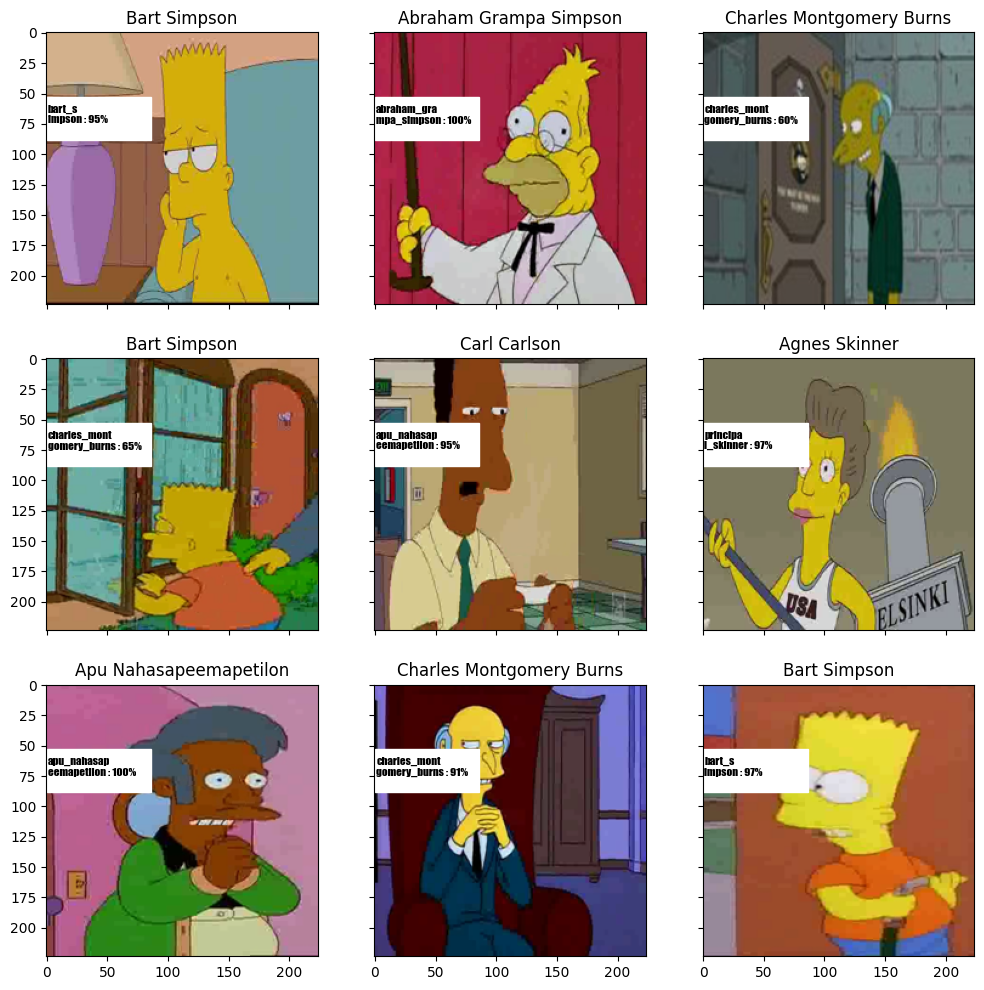

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [595]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [596]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [602]:
import pandas as pd
submission_path = 'sample_submission.csv'
my_submit = pd.read_csv(submission_path)
my_submit.head()

Id      Expected
0  img0.jpg  bart_simpson
1  img1.jpg  bart_simpson
2  img2.jpg  bart_simpson
3  img3.jpg  bart_simpson
4  img4.jpg  bart_simpson

In [603]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [604]:
my_submit.to_csv('my_submission.csv', index=False)
my_submit.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            lisa_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

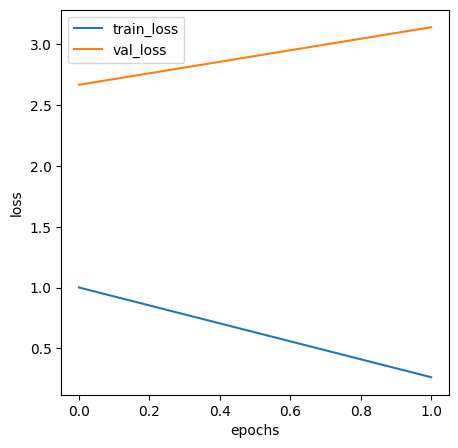

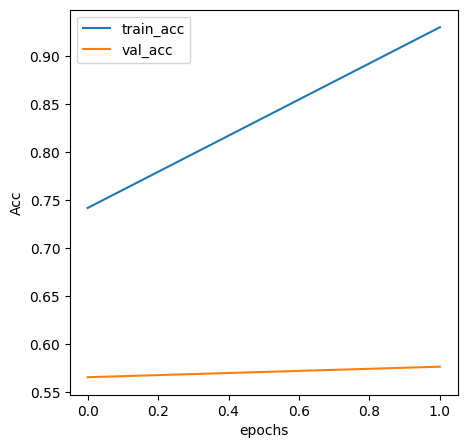

In [527]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

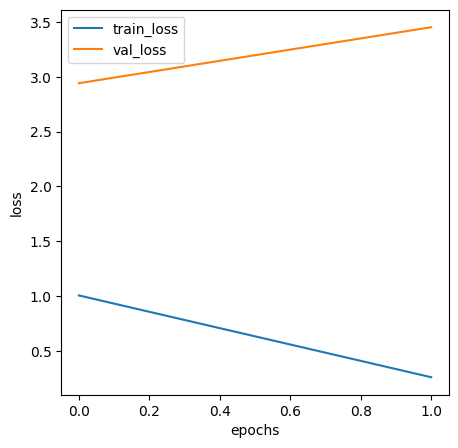

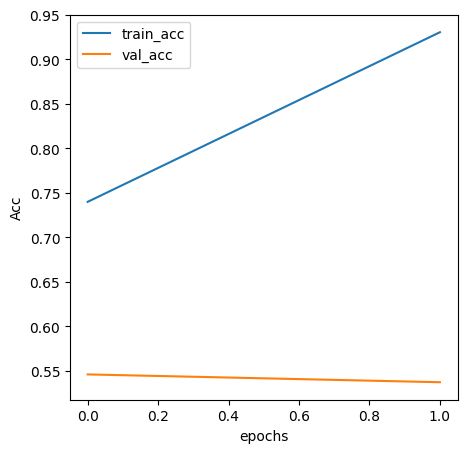

In [517]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

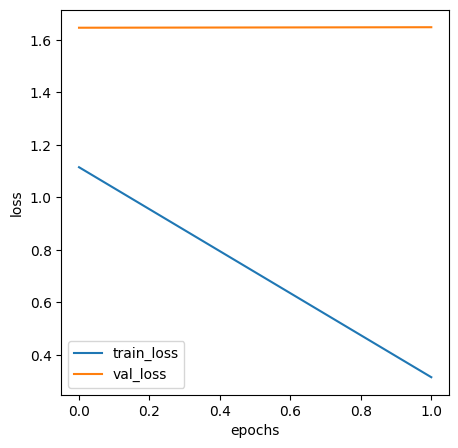

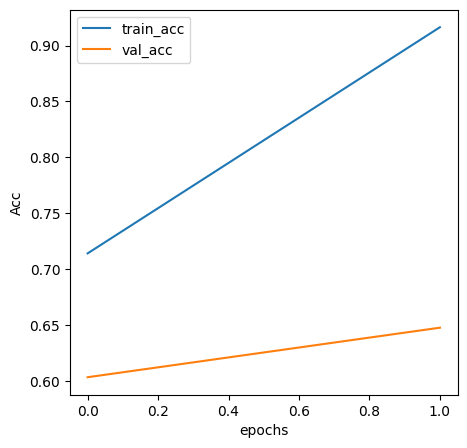

In [496]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

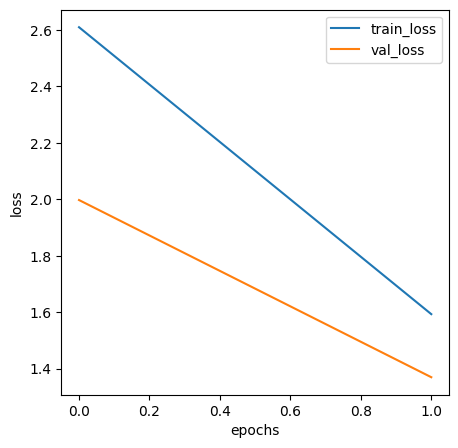

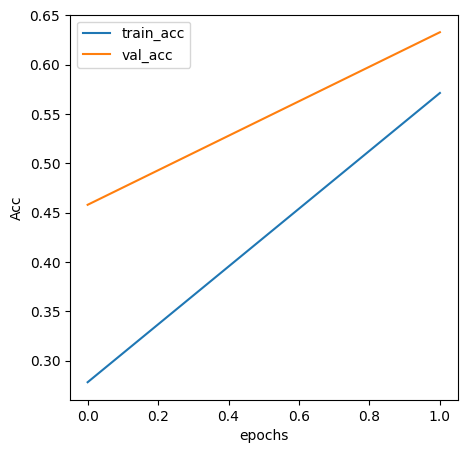

In [463]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

In [467]:
for i,a in train_dataset:
    print(f"i: {i} a: {a}")
    print(f"i.item(): {i.item()}")
    
    break

ValueError: too many values to unpack (expected 1)

In [ ]:
# [1/c.get(i.item()) for i, in ds]

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [499]:
class_count = Counter(train_dataset.labels)
class_weights = {name: 1/cnt for name, cnt in class_count.items()}

sample_weights = [0] * len(train_dataset)
for i, (label) in enumerate(train_dataset.labels):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight
sample_weights

# Максимальное кол-во объкетов = максимальное кол-во записей среди всех классов в трейне * на кол-во классов  
N_train = max(class_count.values()) * len(class_count)


train_sampler = WeightedRandomSampler(sample_weights, num_samples=N_train, replacement=True)
train_sampler

In [ ]:
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#для балансировки классов val
class_count = Counter(val_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(val_dataset)
for i, (label) in enumerate(val_dataset.labels):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight
N_val = max(class_count.values()) * len(class_count)
val_sampler = WeightedRandomSampler(sample_weights, num_samples=N_val, replacement=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=N_CORES)

In [460]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

# датасат из тысячи нулей и 50 единичек. 
ds = TensorDataset(torch.Tensor([ 0 for _ in range(1000)] + [ 1 for _ in range(50)]))

dl = DataLoader(ds, batch_size=50)

# попросим у даталоудера 10 раз по батчу и посчитаем среднее

for _ in range(10):
    print(next(iter(dl))[0].mean())
    
# сейчас здесь всегда нули, потому что мы каждый раз бежим сначала, а там тысяча нулей. просто!

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [461]:
dl = DataLoader(ds, batch_size=50, shuffle=True)

for _ in range(10):
    print(next(iter(dl))[0].mean())

# сейчас здесь не всегда нули, потому что мы каждый раз бежим сначала, но мы перемешали элементы и иногда попадаются единички из конца датасета.
# тоже просто!

tensor(0.0600)
tensor(0.0800)
tensor(0.0200)
tensor(0.0800)
tensor(0.0600)
tensor(0.0400)
tensor(0.0200)
tensor(0.0400)
tensor(0.1000)
tensor(0.0200)


In [462]:
# теперь мы хотим чтобы в каждом батче всегда было примерно 0.5, в каждой итерации по даталоадеру
from collections import Counter

# при итерации по TensorDataset нам будут отдавать туплы такого вида - (tensor(0),)
# то есть нужно взять из тупла первый элемент и потом из тензора выдрать собственно значение - через Tensor.item()

# вау, узнал что можно делать вот такой изящный анпэкинг (запятая после i - обратите внимание!)
# в питоне конструктор для тупла это не скобочки а запятая, ага!
c = Counter(i.item() for i, in ds)
print(c)  
# теперь в c лежит Counter({0: 1000, 1: 50})

weights = [1/c.get(i.item()) for i, in ds]
sampler = WeightedRandomSampler(weights, num_samples=len(weights))

# такс. нужно пояснить - weights это просто тупо "вероятности" вытащить каждый элемент из датасета.
# вероятности в кавычках потому что сумма weights не обязана быть равна 1. он там сам поделит на сумму вестимо.
# почему он просит отдельно передавать  кол-во элементов в num_samples - для меня загадка, но ок.

print(len(weights), sum(weights))
# лен равен длине датасета, ага. сум равен количеству классов (у нас 2 - 0 и 1). понятно почему?)

Counter({0.0: 1000, 1.0: 50})
1050 2.0000000000000013


In [ ]:
# если понятно то теперь мы готовы решить задачку

dl = DataLoader(ds, batch_size=50, sampler=sampler)

for _ in range(10):
    print(next(iter(dl))[0].mean())

# теперь у нас получается всегда примерно 0.5 - а вы великолепны!
# причем тут симпсоны - думаю догадаетесь сами) 

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
train_classes = train_dataset.labels
class_count = Counter(train_classes)

# class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
# # sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]
# # sample_weights
# class_weights
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (label) in enumerate(train_dataset.labels):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight
sample_weights

N_train = max(class_count.values()) * len(class_count)


train_sampler = WeightedRandomSampler(sample_weights, num_samples=N_train, replacement=True)


In [484]:
train_dataset_tmp = SimpsonsDataset(train_files, mode='train')
train_classes = train_dataset_tmp.labels
class_count = Counter(train_classes)
class_weights = {name: 1/cnt for name, cnt in class_count.items()}

sample_weights = [0] * len(train_dataset_tmp)
for i, (label) in enumerate(train_dataset.labels):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight
sample_weights

# Максимальное кол-во объкетов = максимальное кол-во записей среди всех классов в трейне * на кол-во классов  
N_train = max(class_count.values()) * len(class_count)


train_sampler = WeightedRandomSampler(sample_weights, num_samples=N_train, replacement=True)
train_sampler

In [ ]:
#для балансировки классов val
class_count = Counter(val_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(val_dataset)
for i, (label) in enumerate(val_dataset.labels):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight
N_val = max(class_count.values()) * len(class_count)
val_sampler = WeightedRandomSampler(sample_weights, num_samples=N_val, replacement=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=N_CORES)

In [278]:
image = Image.open(train_val_files[100])
image.load()
np.array(image).shape


(416, 288, 3)

In [315]:
np.array(image).shape, transforms.ToTensor()(image).shape, transforms.ToTensor()(image).numpy().shape, np.array(transforms.ToPILImage()(transforms.ToTensor()(image))).shape
# np.array(transforms.ToPILImage()(transforms.ToTensor()(image))) == np.array(image)

((416, 288, 3), torch.Size([3, 416, 288]), (3, 416, 288), (416, 288, 3))

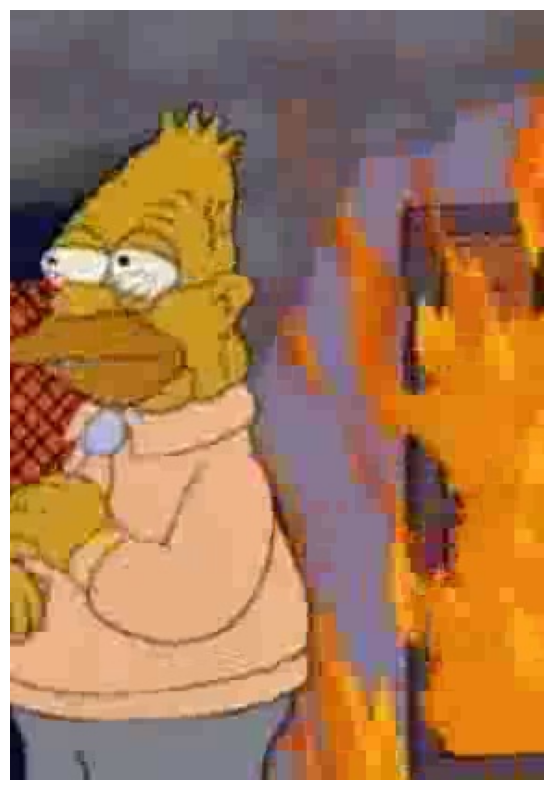

In [322]:
visualize(np.array(transforms.ToPILImage()(transforms.ToTensor()(image))))

In [279]:
from random import uniform
uniform(0.5, 5.0)

3.592500453386705

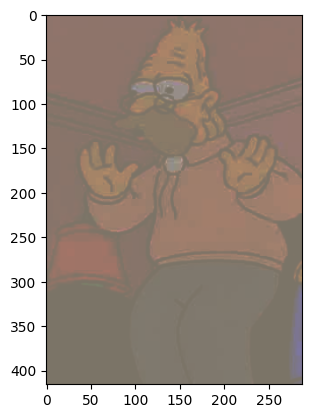

In [280]:
t_image = transforms.ToTensor()(image)
# transforms.functional.adjust_gamma(t_image, gamma = 0.5)
imshow(transforms.functional.adjust_gamma(t_image, gamma = uniform(0.5, 5.0)))

# adjust_gamma
# adjust_gamma
# imshow(transforms.ToTensor()(image))

In [ ]:
import albumentations as A
    
transform = A.Compose([
        A.RandomRotate90(),
        A.ShiftScaleRotate(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
#             A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
#             A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
#             A.IAASharpen(),
#             A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])
# random.seed(42) 
# augmented_image = transform(image=image)['image']
# visualize(augmented_image)


# def visualize(image):
#     plt.figure(figsize=(10, 10))
#     plt.axis('off')
#     plt.imshow(image)
# transform = A.HorizontalFlip(p=0.5)
# new_image = torch.from_numpy(transform(image=im_val.data.numpy())["image"])
# new_image = torch.from_numpy(transform(image=np.array(image))["image"])
# visualize( new_image)
# plt.show()    


image = Image.open(train_val_files[101])
image.load()
# np.array(image).shape
visualize( image)

In [232]:
# transform = A.ShiftScaleRotate(p=0.5)
transform = A.VerticalFlip(p=0.1)

# new_image = torch.from_numpy(transform(image=im_val.data.numpy())["image"])
new_image = torch.from_numpy(transform(image=np.array(image))["image"])

imshow( new_image)
plt.show()

ValueError: operands could not be broadcast together with shapes (3,) (288,3,416) 

In [283]:
augmented_image = transform(image=im_val.data.numpy())["image"]
augmented_image = A.ShiftScaleRotate(im_val.data.numpy())["image"]
imshow(torch.from_numpy(augmented_image) )
# imshow(im_val.data.cpu())
# transform(image=im_val.data)
plt.show()

ValueError: Argument param must be either scalar (int, float) or tuple

In [284]:
augmented_image = transform(image=im_val.data.numpy())["image"]


In [285]:
im_val.data.shape

torch.Size([3, 224, 224])

In [286]:
type(augmented_image)
torch.from_numpy(augmented_image).shape

torch.Size([3, 224, 224])

lisa_simpson


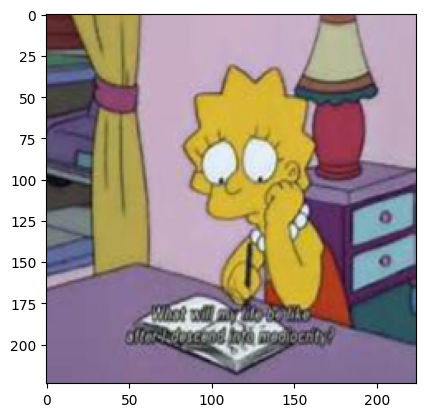

In [287]:
# im_val, label = val_dataset[np.random.randint(3000)]
im_val, label = val_dataset[3000]

labal_name = val_dataset.label_encoder.inverse_transform([label])[0]
print(labal_name)
imshow(im_val.data)
# imshow(im_val.data.cpu())
# transform(image=im_val.data)
plt.show()

# visualize(im_val.data)

In [353]:

labels_counter = Counter(train_val_labels)
# labels_counter = Counter(train_dataset.labels)

for label_name in labels_counter:
    if labels_counter[label_name] < 1000:
        print(f"labels_counter: {label_name}, {labels_counter[label_name]}")
    
# class_weights = {i: 1/c for i, c in labels_counter.items()}
# class_weights
# labels_counter

labels_counter: abraham_grampa_simpson, 913
labels_counter: agnes_skinner, 42
labels_counter: apu_nahasapeemapetilon, 623
labels_counter: barney_gumble, 106
labels_counter: carl_carlson, 98
labels_counter: chief_wiggum, 986
labels_counter: cletus_spuckler, 47
labels_counter: comic_book_guy, 469
labels_counter: disco_stu, 8
labels_counter: edna_krabappel, 457
labels_counter: fat_tony, 27
labels_counter: gil, 27
labels_counter: groundskeeper_willie, 121
labels_counter: kent_brockman, 498
labels_counter: lenny_leonard, 310
labels_counter: lionel_hutz, 3
labels_counter: maggie_simpson, 128
labels_counter: martin_prince, 71
labels_counter: mayor_quimby, 246
labels_counter: miss_hoover, 17
labels_counter: nelson_muntz, 358
labels_counter: otto_mann, 32
labels_counter: patty_bouvier, 72
labels_counter: professor_john_frink, 65
labels_counter: rainier_wolfcastle, 45
labels_counter: ralph_wiggum, 89
labels_counter: selma_bouvier, 103
labels_counter: sideshow_bob, 877
labels_counter: sideshow_me

In [330]:
# Counter(train_dataset.labels)

In [355]:
import pandas as pd
from torch.utils.data.sampler import WeightedRandomSampler

In [345]:
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (label) in enumerate(train_dataset.labels):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight
sample_weights
class_weights

{'abraham_grampa_simpson': 0.00145985401459854,
 'agnes_skinner': 0.03125,
 'apu_nahasapeemapetilon': 0.0021413276231263384,
 'barney_gumble': 0.0125,
 'bart_simpson': 0.0009940357852882703,
 'carl_carlson': 0.013513513513513514,
 'charles_montgomery_burns': 0.0011173184357541898,
 'chief_wiggum': 0.0013531799729364006,
 'cletus_spuckler': 0.02857142857142857,
 'comic_book_guy': 0.002840909090909091,
 'disco_stu': 0.16666666666666666,
 'edna_krabappel': 0.0029154518950437317,
 'fat_tony': 0.05,
 'gil': 0.05,
 'groundskeeper_willie': 0.01098901098901099,
 'homer_simpson': 0.0005938242280285036,
 'kent_brockman': 0.002680965147453083,
 'krusty_the_clown': 0.0011061946902654867,
 'lenny_leonard': 0.004291845493562232,
 'lionel_hutz': 0.5,
 'lisa_simpson': 0.0009852216748768472,
 'maggie_simpson': 0.010416666666666666,
 'marge_simpson': 0.0010330578512396695,
 'martin_prince': 0.018867924528301886,
 'mayor_quimby': 0.005405405405405406,
 'milhouse_van_houten': 0.0012360939431396785,
 'miss

In [356]:
train_dataset = SimpsonsDataset(train_files, mode='train')
train_classes = train_dataset.labels
class_count = Counter(train_classes)

# class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
# # sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]
# # sample_weights
# class_weights
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (label) in enumerate(train_dataset.labels):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight
sample_weights

N_train = max(class_count.values()) * len(class_count)


train_sampler = WeightedRandomSampler(sample_weights, num_samples=N_train, replacement=True)


In [360]:
type(train_sampler)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=N_CORES)
# train_sampler.
https://www.kaggle.com/code/vladislavzenin/weightedrandomsampler

SyntaxError: invalid syntax (2191965180.py, line 4)

In [ ]:
# Note the trasnformations should include ToTensor() in this case.
data = datasets.ImageFolder('/path/to/images', transform=loader_transform)

# Split into train/test sets:
train_len = int(len(data)*0.8)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

# Create torch dataloaders:
train_loader = DataLoader(train_set, batch_size=4, sampler=sampler, num_workers=12)
print("The number of images in a training set is:", len(train_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=12)
print("The number of images in a test set is:", len(test_loader)*batch_size)

In [367]:
train_dataset.__getitem__(1)

TypeError: adjust_gamma() missing 1 required positional argument: 'img'

In [363]:
type(train_dataset)

__main__.SimpsonsDataset

In [375]:
numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print(f"target train 0/1: {len(np.where(target == 0)[0])}/{len(np.where(target == 1)[0])}")

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)
sampler.weights

target train 0/1: 900/100


tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20,10))
ax[0].barh(tr_labels_count.index, tr_labels_count)
ax[1].barh(y.index, y)
fig.tight_layout()
plt.show()